In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import tensorflow as tf
import scipy.stats
import pandas as pd
from tensorflow.contrib.metrics import streaming_pearson_correlation

/Users/nlarusstone/.virtualenvs/mphil/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
n_experiments = df.shape[0]
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [3]:
flux_dfs = []
btol_col = None
for i in range(n_experiments):
    d = pd.read_csv('../data/flux_samps_lrg/fluxes_{0}'.format(i), index_col=0)
    new_btol_col = d.columns.get_loc('DM_btol_c')
    if btol_col:
        assert(new_btol_col == btol_col)
    else:
        btol_col = new_btol_col
    flux_dfs.append(d)

In [4]:
max_sz = (None, None)
for d in flux_dfs:
    if d.shape[1] > max_sz[0]:
        max_sz = (d.shape[1], d.columns)

In [5]:
fluxes = []
for d in flux_dfs:
    vals = d.reindex(columns=max_sz[1]).fillna(0)
    assert(vals.columns.get_loc('DM_btol_c') == btol_col)
    fluxes.append(vals.values)
samp_data = np.stack(fluxes, axis=1)

In [20]:
np.random.seed(42)
n_rows = 20000
resamp_data = np.empty((n_rows, n_experiments, max_sz[0]))
for j in range(n_rows):
    #exps = []
    inds = np.random.choice(range(samp_data.shape[0]), size=n_experiments, replace=True)
    for i in range(n_experiments):
        ind = inds[i]
        flxs = samp_data[ind, i, :]
        resamp_data[j][i][:] = flxs
        #exps.append(flxs)
    #resamp_data_l.append(exps)
    if j % (n_rows / 10) == 0:
        print j
#resamp_data = np.stack(resamp_data_l)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000


In [ ]:
np.save(arr=resamp_data, file='../data/fluxes_resampled_20k')

In [26]:
10

10

In [4]:
data = np.load('../data/fluxes_ecoli_biomass.npy')
#rxns = np.load('../data/rxns_ecoli_but.npy')
data_no_nan = np.nan_to_num(x=data)
data.shape

(1258, 41, 2586)

In [5]:
flat_data = np.reshape(data_no_nan, (data.shape[0] * data.shape[1], data.shape[2]))

In [ ]:
np.random.seed(seed=42)
def gen_train_test(data):
    train_ind = np.random.choice(data.shape[0], size=int(0.9 * data.shape[0]), replace=False)
    test_ind = list(set(range(data.shape[0])) - set(train_ind))
    min_val = np.min(data)
    max_val = np.max(data)
    # mn = np.mean(flat_data)
    #std = np.std(flat_data)
    #norm = lambda x: (x - mn) / std
    scale = lambda x: (x + abs(min_val)) / (abs(min_val) + max_val)
    data_scaled = scale(data)
    y = np.array(range(41) * data.shape[0])
    return data_scaled[train_ind], y[train_ind], data_scaled[test_ind], y[test_ind]
#gen_train_test(flat_data)
#gen_train_test(data_no_nan)
X_train, y_train, X_test, y_test = gen_train_test(resamp_data)

In [ ]:
latent_dim = 2
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], n_experiments, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def corr(y_pred, y_true):
    cent_pred = y_pred - K.mean(y_pred)
    cent_tr = y_true - K.mean(y_true)

    std_pred = K.std(y_pred)
    std_tr = K.std(y_true)

    return K.mean(cent_pred*cent_tr)/(std_pred*std_tr)

def build_vae(X_shape, n_experiments, targets, output_ind, batch_size=100):
    encoded_dim1 = 1024
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(n_experiments, X_shape,))
    #h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(x)#h)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(n_experiments,latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    #decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='sigmoid')
    h_decoded = decoder_h(z)
    #h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)#2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    output_flux = x_decoded_mean[:, :, output_ind]
    #experiment_loss = scipy.stats.spearmanr(targets, output_flux)
    experiment_loss = corr(output_flux, targets)#streaming_pearson_correlation(output_flux, targets)
    xent_loss = X_shape * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss) + experiment_loss
    #vae_loss = K.sum(vae_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(n_experiments, latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    #_h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)#2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [ ]:
#%%debug
batch_size = 256
X_shape, n_experiments = X_train.shape[2], df.shape[0]
targets = tf.convert_to_tensor(df['AVG.1'].values, dtype=tf.float32)
output_ind = btol_col
vae, encoder, generator = build_vae(X_shape, n_experiments, targets, output_ind, batch_size)
es = EarlyStopping(patience=2)
vae.fit(X_train,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es])

In [156]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
x_test_gen = generator.predict(x_test_encoded, batch_size=batch_size)
#x_test_encoded

In [157]:
corrs = []
for i in range(x_test_gen.shape[0]):
    corr = scipy.stats.pearsonr(x_test_gen[i, :, btol_col], df['AVG.1'])
    corrs.append(corr)
corrs

[(-0.1128489271235683, 0.4823746103985559),
 (-0.04372449048232652, 0.7860489063524729),
 (-0.2852308512309134, 0.07066172397634705),
 (-0.04792098507896988, 0.7660651742037465),
 (-0.19755838309603535, 0.21567276346729797),
 (-0.17316545123850663, 0.27893487757128044),
 (-0.2944919950106911, 0.061617197174680775),
 (-0.011011338304225819, 0.9455241271598973),
 (-0.25970764647191774, 0.10104946750201957),
 (-0.11367626524740215, 0.4791488250823016),
 (-0.15244886581757838, 0.3413309403656647),
 (0.0760021289506085, 0.636723137536932),
 (0.048530824564743995, 0.7631731877189014),
 (-0.1532796023162593, 0.3386752413668993),
 (-0.30010248298714887, 0.05660242695571823),
 (-0.03129591376288619, 0.8459864752471413),
 (-0.16963854126058417, 0.2889927402186868),
 (-0.25326820004988243, 0.11010341942388083),
 (-0.07266187132588964, 0.651649268500643),
 (-0.056184416136064494, 0.7271598618710133),
 (-0.04337570996971529, 0.7877161081633955),
 (-0.31939220937977647, 0.04179837287788901),
 (-0.13

In [387]:
np.std(x_test_encoded, axis=0)

array([3.4379508e-10, 9.0804404e-09, 1.5861275e-09], dtype=float32)

In [359]:
preds = generator.predict(x_test_encoded)
preds[0]

array([0.45933554, 0.4593587 , 0.4594071 , ..., 0.45931953, 0.45938182,
       0.459394  ], dtype=float32)

In [360]:
X_test[0]

array([0.4578113 , 0.4578113 , 0.45781122, ..., 0.45781122, 0.45781122,
       0.45781122])

In [361]:
mse = metrics.mse(y_pred=preds, y_true=X_test_scale)

In [362]:
s = tf.get_default_session()
K.set_session(session=s)
sess = K.get_session()
mns = mse.eval(session=sess)

In [363]:
mns

array([1.70036055, 1.70049099, 1.6992244 , ..., 1.70043739, 1.69860465,
       1.7003055 ])

In [47]:
def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new
#get_rct(df, 'Glucose', y_test)

In [45]:
x_test_encoded.shape

(126, 41, 2)

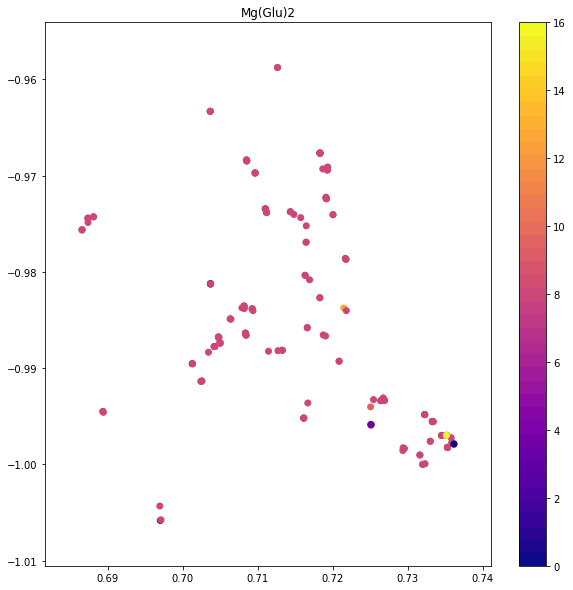

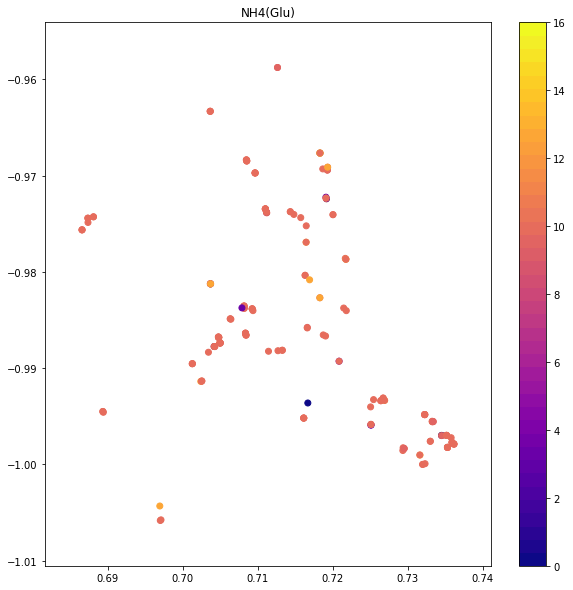

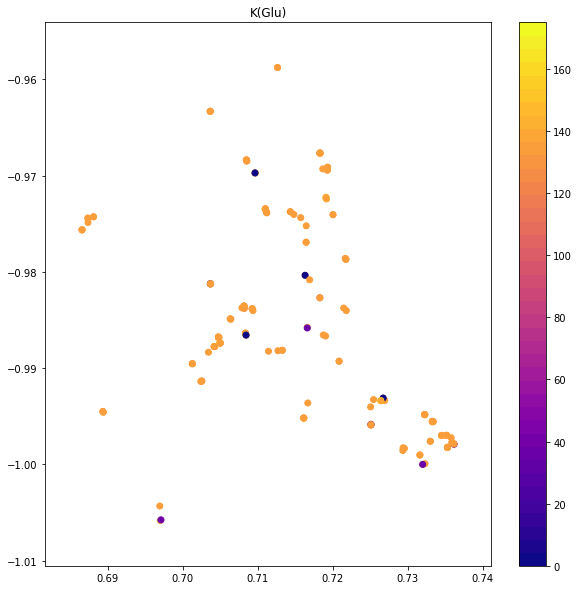

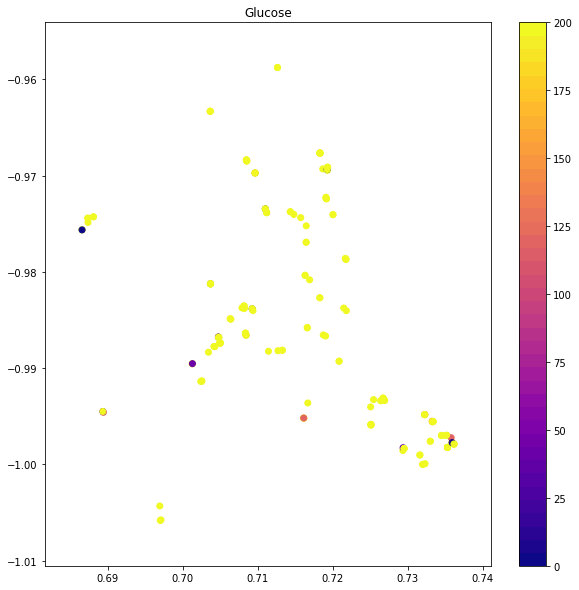

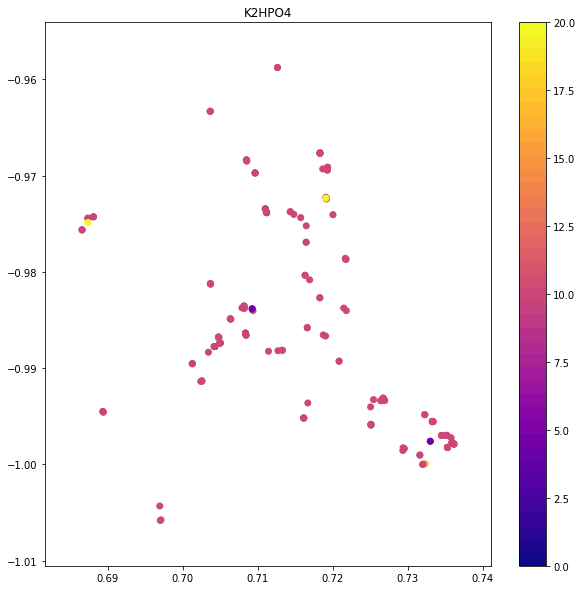

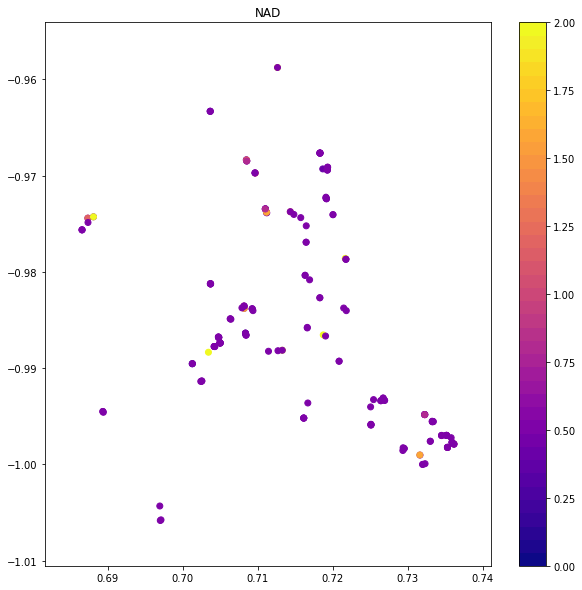

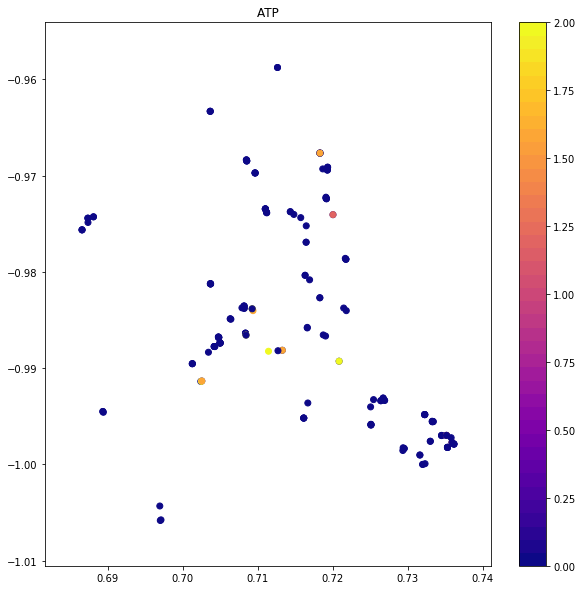

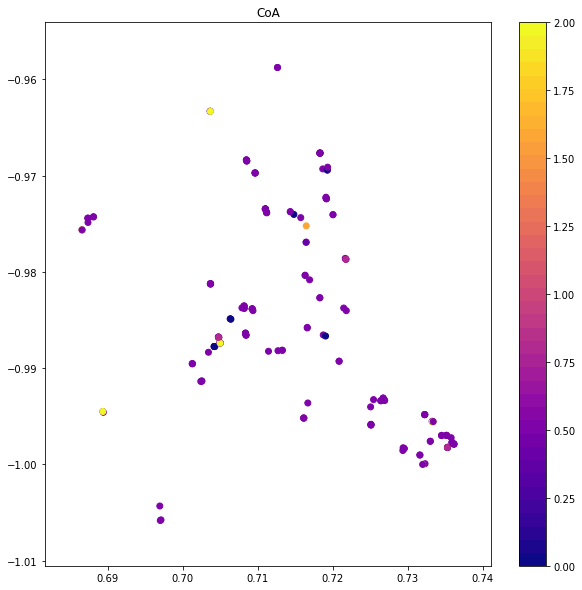

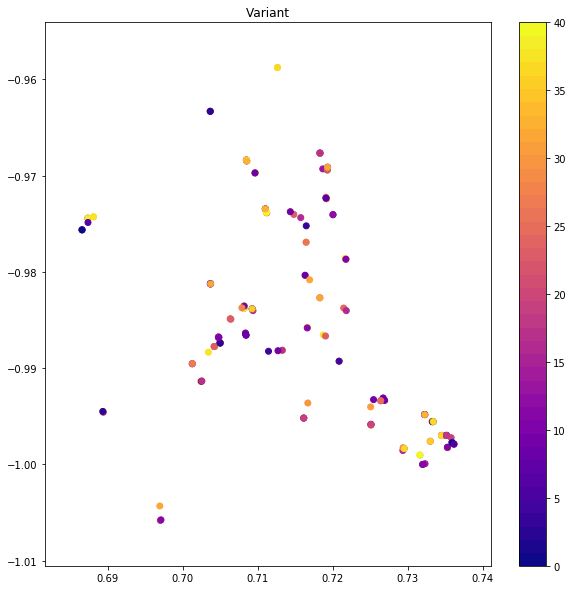

In [158]:
#cm1 = cm.get_cmap('tab20b', 20)
#cm2 = cm.get_cmap('tab20c', 20)
cmap = cm.get_cmap('plasma', 41)
#cmap = lambda x: cm1(x) if x < 21 else cm2(x)
#for j in range(41):
j = 0
xmin, xmax = np.amin(x_test_encoded[:, j, 0]), np.amax(x_test_encoded[:, j, 0])
ymin, ymax = np.amin(x_test_encoded[:, j, 1]), np.amax(x_test_encoded[:, j, 1])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
for col in df.columns[4:]:
    plt.figure(figsize=(10, 10))
    plt.scatter(x_test_encoded[:, j, 0], x_test_encoded[:, j, 1], c=get_rct(df, col, y_test), cmap=cmap)
    plt.xlim((xmin - x_diff, xmax + x_diff))
    plt.ylim((ymin - y_diff, ymax + y_diff))
    plt.title(col)
    plt.colorbar()
    plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, j, 0], x_test_encoded[:, j, 1], c=y_test, cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title('Variant')
plt.colorbar()
plt.show()

In [223]:
df.columns[3:]

Index([u'STD.1', u'Mg(Glu)2', u'NH4(Glu)', u'K(Glu)', u'Glucose', u'K2HPO4',
       u'NAD', u'ATP', u'CoA'],
      dtype='object')

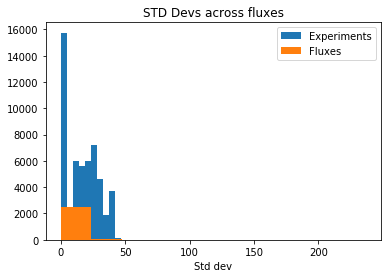

In [390]:
std_trials = np.std(flat_data, axis=1)
std_fluxes = np.std(flat_data, axis=0)
plt.hist(std_trials, label='Experiments')
plt.title('STD Devs across experiments')
plt.hist(std_fluxes, label='Fluxes')
plt.title('STD Devs across fluxes')
plt.xlabel('Std dev')
plt.legend()
plt.show()

In [393]:
sor_flux = np.argsort(std_fluxes)

In [394]:
sor_flux

array([1292, 1053, 1115, ...,  184, 1540,  749])